In [1]:
from data import Portfolio, Dataset
from utils import *
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from sklearn.linear_model import LogisticRegression

In [2]:
# define stock list of portfolio
stock_list = ['AXP', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'XOM', 'GS', 'HD', 'IBM', 'INTC', 'JNJ', \
	'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PFE', 'PG', 'TRV', 'UNH', 'RTX', 'VZ', 'V', 'WBA', \
	'WMT', 'DIS']

# define desired start and end dates
start = '1990-01-01'
end = '2020-01-01'

# construct pandas dataframe of portfolio returns to instantiate Portfolio object 
# (in this case from yfinance)
returns = yf.Ticker('^DJI').history(start=start,end=end)

# construct Portfolio object implemented in data.py
dowjones = Portfolio('^DJI', stock_list, returns, start=start,end=end)

Before proceeding with our analysis, we can graph the historic returns of our stocks using the price_plot() class method of our Portfolio object. We choose to use the Open price as an example here, but we can also choose to graph the Close, High, or Low prices as well. We first plot the returns of the portfolio itself (in this case, just the Dow Jones index).

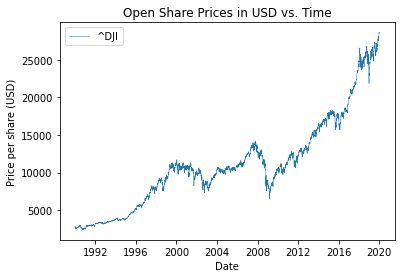

In [3]:
ax1 = dowjones.price_plot(['returns'],'Open',start,end)
plt.show()

We can plot the historical price of a few stocks for reference: in this case, the canonical tech and finance stocks.  

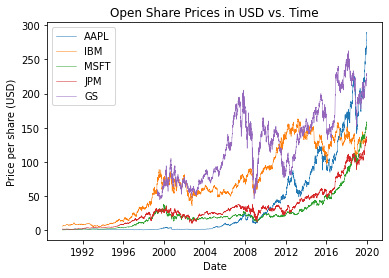

In [4]:
ax1 = dowjones.price_plot(['AAPL', 'IBM', 'MSFT','JPM', 'GS'],'Open',start,end)
plt.show()

**Feature space:** We now proceed to constructing the features that will be used to predict the movement of the Dow Jones. As per described in Krauss et al., 2016, we consider the price process $P^s_{t \in T}$ for a stock $s$, and define the return over a period of duration $m$ as:

$$R^s_{t,m} = \frac{P^s_t}{P^s_{t-m}} - 1$$

In considering daily data, as suggested in the paper, we consider $m \in \{1, \cdots 20\} \cup \{40, 60, \cdots, 240 \}$. This amounts to first focusing on the returns of the first 20 days (high resolution), and then consider multi-period returns corresponding to longer time scales (low resolution). This yields a total of 31 features for each stock.

**Output space:** In a slight deviation from the paper, we instead construct a binary response variable $Y^r_{t+1, 1} \in \{0, 1\}$ where $r$ represents the returns of the portfolio; in this simple example, we consider the movement of the Dow Jones index based on the previous day. That is, if the price goes up on day $t+1$, $Y^r_{t+1, 1} = 1$, and if it goes down, $Y^r_{t+1, 1} = 0$.

**Dataset generation:** We now instantiate a dataset consisting of our desired periods and features (stocks) using the implemented Dataset class. Note that the implemented class is flexible to target and feature choice, as well as period selection.

In [5]:
# define feature names, target name, periods
feature_names = stock_list
target_name = 'returns'
periods = list(range(1,21)) + list(range(40,260,20))

# instantiate data object 
dowjones_data = Dataset(dowjones, 'Open', feature_names, periods, target_name)

In [6]:
print("Number of features", dowjones_data.n_features)
print("Number of classes", dowjones_data.n_classes)
print("Number of datapoints", dowjones_data.n_samples)

Number of features 900
Number of classes 2
Number of datapoints 7318


In [7]:
print('Number of negative movement days in ^DJI', dowjones_data.target[dowjones_data.target == 0].shape[0])
print('Number of positive movement days in ^DJI', dowjones_data.target[dowjones_data.target == 1].shape[0])

Number of negative movement days in ^DJI 3386
Number of positive movement days in ^DJI 3932


Our feature matrix is thus 7318 x 900 in dimension. We also note that our classes are relatively balanced with one another.

We first explore the summary statistics of our features by invoking the .statistics() instance method (also flexible with respect to feature and period selection). As an exercise, we display the summary statistics of the 10-day returns for the stocks plotted above. 

In [8]:
df_stat = dowjones_data.statistics(features=['AAPL', 'IBM', 'MSFT','JPM', 'GS'],periods=[10])
display(df_stat)

,"(AAPL, 10)","(IBM, 10)","(MSFT, 10)","(JPM, 10)","(GS, 10)"
count,7318.000000,7318.000000,7318.000000,7318.000000,5190.000000
mean,0.011394,0.005136,0.009127,0.009057,0.004749
std,0.086559,0.052908,0.056994,0.067206,0.063705
var,0.007492,0.002799,0.003248,0.004517,0.004058
kurtosis,5.965171,2.781818,2.425856,6.285873,3.981627
skewness,0.026533,0.188881,0.252276,0.583260,0.089509
min,-0.623978,-0.254252,-0.286087,-0.398408,-0.371436
25%,-0.036649,-0.023505,-0.022482,-0.026124,-0.030898
50%,0.010659,0.004078,0.008821,0.007694,0.005059
75%,0.057579,0.033045,0.038832,0.042125,0.037890


We see here that the returns for some periods/stocks have high degree of kurtosis/skewness, indicating the non-Gaussianity of our returns.


We can also construct a correlation matrix from the data by invoking the corr_plot() instance method on our object: 

[TODO: correlation matrix is very slow in Jupyter]

In [9]:
dowjones_data.data

,"(AXP, 1)","(AXP, 2)","(AXP, 3)","(AXP, 4)","(AXP, 5)","(AXP, 6)","(AXP, 7)","(AXP, 8)","(AXP, 9)","(AXP, 10)",...,"(DIS, 60)","(DIS, 80)","(DIS, 100)","(DIS, 120)","(DIS, 140)","(DIS, 160)","(DIS, 180)","(DIS, 200)","(DIS, 220)","(DIS, 240)"
Date,,,,,,,,,,,,,,,,,,,,,
1990-12-13,0.028571,0.016949,0.005587,-0.021739,-0.057592,0.046512,0.052632,0.071429,0.104294,0.104294,...,0.119658,0.039683,-0.149351,-0.162939,-0.101201,-0.034991,-0.040293,-0.009452,0.033531,-0.049002
1990-12-14,-0.022222,0.005714,-0.005650,-0.016760,-0.043478,-0.078534,0.023256,0.029240,0.047619,0.079755,...,0.169265,0.054217,-0.126456,-0.151858,-0.091696,-0.024164,-0.029575,0.005747,0.043738,-0.048913
1990-12-17,-0.022727,-0.044444,-0.017143,-0.028249,-0.039106,-0.065217,-0.099476,0.000000,0.005848,0.023810,...,0.176471,0.078838,-0.120135,-0.150327,-0.131886,-0.040590,-0.029851,-0.013283,0.059063,-0.056261
1990-12-18,0.005814,-0.017045,-0.038889,-0.011429,-0.022599,-0.033520,-0.059783,-0.094241,0.005814,0.011696,...,0.162528,0.079665,-0.122658,-0.173355,-0.165316,-0.049815,-0.042751,-0.037383,0.011788,-0.080357
1990-12-19,0.034682,0.040698,0.017045,-0.005556,0.022857,0.011299,0.000000,-0.027174,-0.062827,0.040698,...,0.174208,0.023669,-0.100520,-0.181388,-0.180095,-0.049451,-0.054645,-0.040665,-0.003839,-0.079787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,-0.006260,-0.007216,0.006175,-0.000646,0.007731,-0.005541,0.020269,0.036061,0.033639,0.037363,...,0.115845,0.051720,0.031609,0.028454,0.072075,0.096217,0.265914,0.275743,0.309364,0.304520
2019-12-26,0.000242,-0.006019,-0.006975,0.006419,-0.000404,0.007975,-0.005300,0.020516,0.036312,0.033890,...,0.118289,0.072588,0.051262,0.028798,0.069590,0.089955,0.251722,0.281622,0.335415,0.318223
2019-12-27,0.006863,0.007107,0.000803,-0.000160,0.013326,0.006456,0.014893,0.001526,0.027519,0.043424,...,0.143338,0.074450,0.046428,0.048984,0.064504,0.111492,0.255696,0.295459,0.353317,0.316477


However, it is likely that some of the values do not exist due to the stock being added into the Dow Jones after 1990. Thus, for machine learning, we drop all columns where there is at least one NaN. 

In [10]:
dowjones_data.data = dowjones_data.data.dropna(axis='columns')

In [11]:
dowjones_data.data

,"(AXP, 1)","(AXP, 2)","(AXP, 3)","(AXP, 4)","(AXP, 5)","(AXP, 6)","(AXP, 7)","(AXP, 8)","(AXP, 9)","(AXP, 10)",...,"(DIS, 60)","(DIS, 80)","(DIS, 100)","(DIS, 120)","(DIS, 140)","(DIS, 160)","(DIS, 180)","(DIS, 200)","(DIS, 220)","(DIS, 240)"
Date,,,,,,,,,,,,,,,,,,,,,
1990-12-13,0.028571,0.016949,0.005587,-0.021739,-0.057592,0.046512,0.052632,0.071429,0.104294,0.104294,...,0.119658,0.039683,-0.149351,-0.162939,-0.101201,-0.034991,-0.040293,-0.009452,0.033531,-0.049002
1990-12-14,-0.022222,0.005714,-0.005650,-0.016760,-0.043478,-0.078534,0.023256,0.029240,0.047619,0.079755,...,0.169265,0.054217,-0.126456,-0.151858,-0.091696,-0.024164,-0.029575,0.005747,0.043738,-0.048913
1990-12-17,-0.022727,-0.044444,-0.017143,-0.028249,-0.039106,-0.065217,-0.099476,0.000000,0.005848,0.023810,...,0.176471,0.078838,-0.120135,-0.150327,-0.131886,-0.040590,-0.029851,-0.013283,0.059063,-0.056261
1990-12-18,0.005814,-0.017045,-0.038889,-0.011429,-0.022599,-0.033520,-0.059783,-0.094241,0.005814,0.011696,...,0.162528,0.079665,-0.122658,-0.173355,-0.165316,-0.049815,-0.042751,-0.037383,0.011788,-0.080357
1990-12-19,0.034682,0.040698,0.017045,-0.005556,0.022857,0.011299,0.000000,-0.027174,-0.062827,0.040698,...,0.174208,0.023669,-0.100520,-0.181388,-0.180095,-0.049451,-0.054645,-0.040665,-0.003839,-0.079787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,-0.006260,-0.007216,0.006175,-0.000646,0.007731,-0.005541,0.020269,0.036061,0.033639,0.037363,...,0.115845,0.051720,0.031609,0.028454,0.072075,0.096217,0.265914,0.275743,0.309364,0.304520
2019-12-26,0.000242,-0.006019,-0.006975,0.006419,-0.000404,0.007975,-0.005300,0.020516,0.036312,0.033890,...,0.118289,0.072588,0.051262,0.028798,0.069590,0.089955,0.251722,0.281622,0.335415,0.318223
2019-12-27,0.006863,0.007107,0.000803,-0.000160,0.013326,0.006456,0.014893,0.001526,0.027519,0.043424,...,0.143338,0.074450,0.046428,0.048984,0.064504,0.111492,0.255696,0.295459,0.353317,0.316477


We see that our new data only has 742 features! To better understand the shape of our data, we can visualize the first two components using PCA:

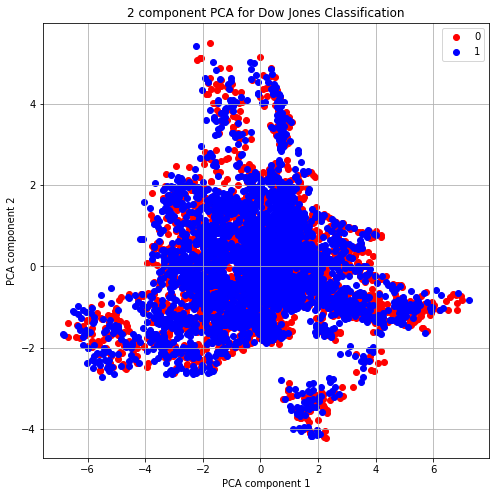

In [12]:
# visualize using PCA
from sklearn.decomposition import PCA

X = dowjones_data.data
y = dowjones_data.target.to_numpy()

X_pca = PCA(n_components=2).fit_transform(X)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PCA component 1')
ax.set_ylabel('PCA component 2')
ax.set_title('2 component PCA for Dow Jones Classification')
targets = [0, 1]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    idxs = np.argwhere(y == target)
    ax.scatter(X_pca[idxs,0], X_pca[idxs,1], c = color)
ax.legend(targets)
ax.grid()

We see in our PCA plot that the data does not appear to be linearly separable (as expected) based on a linear algorithm alone. We can also try applying some nonlinear manifold learning algorithms to see whether we can separate this data in another way: for example, tSNE. This is just for exploration purposes, but ideally we'd do some parameter tuning to see whether we can improve the plot in any way.

(7318, 2)


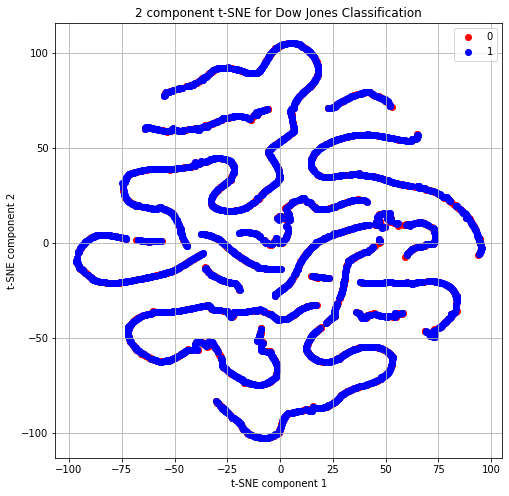

In [13]:
# visualize using tSNE

from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2).fit_transform(X)
print(X_tsne.shape)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('t-SNE component 1')
ax.set_ylabel('t-SNE component 2')
ax.set_title('2 component t-SNE for Dow Jones Classification')
targets = [0, 1]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    idxs = np.argwhere(y == target)
    ax.scatter(X_tsne[idxs,0], X_tsne[idxs,1], c = color)
ax.legend(targets)
ax.grid()

Apart from this embedding looking very weird, it also looks like there is a high degree of non-separability in the features, which may pose an issue to classification.

Let us first try a simple brute force GridSearchCV-aided XGBoost with 5-fold validation to see what we can get out of the raw features without any preprocessing or normalization:

Because we are not dealing with an explicit class imbalance, we choose our metric to be ROC-AUC.

In [19]:
from sklearn.model_selection import GridSearchCV

def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='roc_auc',
                       do_probabilities = False):
    
    gs = GridSearchCV(estimator=model,param_grid=param_grid, cv=cv, n_jobs=-1, scoring=scoring_fit,verbose=2)
    
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      preds = fitted_model.predict_proba(X_test_data)
    else:
      preds = fitted_model.predict(X_test_data)
    
    return fitted_model, preds

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
import xgboost as xgb

params = {'objective':['binary:logistic'],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [6, 10, 20, 100],
              'min_child_weight': [5, 11, 20],
              'colsample_bytree': [0.3, 0.4, 0.7],
              'n_estimators': [1000]}

xgb_model = xgb.XGBClassifier()

model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, xgb_model, params, cv=5)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed: 58.0min
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed: 129.2min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 248.3min finished


In [24]:
print(model.best_score_)

0.8483838424640503


In [25]:
print(model.best_params_)

{'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 20, 'n_estimators': 1000, 'objective': 'binary:logistic'}
